In [8]:
import matplotlib.pyplot as plt

# La partícula libre

A continuación incluimos varías fórmulas para simular la dinámica de una partícula libre en distintos escenarios. El propósito de esta unidad es ilustrar cómo simular este sistema con OpenMM para que el lector tenga ejemplos con los que armar su propia simulación. Se incluye la referencia a la librería UIBCDF_Tests_Systems donde se pueden encontrar clases y métodos para ejecutar sencillas simulaciones de este sistema de una manera rápida y cómoda.

- Hablar de la difusión

## Simulación de dinámica clásica newtoniana

La dinámica clásica newtoniana de un sistemas sencillo como la partícula libre puede ser simulada como una dinámica de Langevin a temperatura cero. De esta manera podemos aprovechar la inclusión de una fuerza externa de fricción en el modelo.

Con `friction=0/unit.picoseconds` el siguiente script nos permite simular una dinámica clásica de partícula libre. En el caso de elegir un valor distinto de cero, podemos simular la particula libre en un medio viscoso -con fricción-.

In [12]:
# %load scripts/particula_libre_newtoniana_1.py
import numpy as np
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

# Definición del sistema.
n_particles = 1 # número de partículas
mass = 180.15 * unit.amu # masa de la glucosa

# Definición de las condiciones del estado termodinámico.
temperature = 0*unit.kelvin # temperatura a zero para que langevin simule la dinámica clásica

# Condiciones iniciales
initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.nanometers # posiciones iniciales
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.nanometers/unit.picoseconds # velocidades iniciales

# Parámetros de la simulación.
integration_timestep = 0.1*unit.picoseconds # paso del integrador
saving_timestep = 1*unit.picoseconds # tiempo de guardado
total_time = 1*unit.nanoseconds # tiempo total de simulación

n_steps = int(round(total_time/integration_timestep)) # número total de pasos de integración a simular
steps_per_cicle = int(round(saving_timestep/integration_timestep)) # pasos de integración por ciclo de guardado
n_cicles = int(round(n_steps/steps_per_cicle)) # número total de ciclos de guardado a simular

# Creación del sistema.
system = mm.System()
for ii in range(n_particles):
    system.addParticle(mass)

# Creación del integrador.
friction = 5.0/unit.picosecond # fricción del sistema (0.0/unit.picoseconds si no queremos fricción)
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Creación de la plataforma.
platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

# Creación del contexto.
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

# Creación de arrays reporteros del tiempo, la posición y la velocidad.
times = np.zeros([n_cicles], np.float32) * unit.picoseconds
positions = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocities = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole

# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0
state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Ejecuto el bucle sobre el número de ciclos de guardado que vamos a simular
for ii in range(1,n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

# Guardo, si es necesario, en un fichero pickle el resultado de la simulación
filename_traj = 'free_particle.pickle'
file_traj = open(filename_traj,'wb')
pickle.dump( times, file_traj )
pickle.dump( positions, file_traj )
pickle.dump( velocities, file_traj )
pickle.dump( kinetic_energy, file_traj )
pickle.dump( potential_energy, file_traj )
file_traj.close()

Podemos también simular este sistema desde la librería UIBCDF_tests_systems de una manera mas cómoda.

In [3]:
# %load scripts/particula_libre_newtoniana_2.py
from uibcdf_test_systems import FreeParticle
from uibcdf_test_systems.simulation import newtonian
from simtk import unit


# Sistema de test con el sistema de OpenMM como atributo
free_particle = FreeParticle(n_particles = 1, mass = 64 * unit.amu)

# Posiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
initial_velocities[0,0] = 0.10 * unit.nanometers/unit.picoseconds

# Simulación Newtoniana
time, position, velocity, kinetic_energy, potential_energy = newtonian (free_particle.system,
                                                                        initial_positions = initial_positions,
                                                                        initial_velocities = initial_velocities,
                                                                        integration_timestep = 0.02 * unit.picoseconds,
                                                                        saving_timestep = 0.5 * unit.picoseconds,
                                                                        total_time = 10 * unit.picoseconds)


Podemos con el esquema anterior ilustrar el resultado de la dinámica clásica newtoniana de una particula libre. Veamos en primer lugar el caso de la partícula sin fricción, totalmente libre:

In [5]:
from uibcdf_test_systems import FreeParticle
from uibcdf_test_systems.simulation import newtonian
import numpy as np
from simtk import unit

free_particle = FreeParticle(n_particles = 1, mass = 64 * unit.amu)

initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
initial_velocities[0,0] = 0.10 * unit.nanometers/unit.picoseconds

time, position, velocity, kinetic_energy, potential_energy = newtonian (free_particle.system,
                                                                        initial_positions = initial_positions,
                                                                        initial_velocities = initial_velocities,
                                                                        integration_timestep = 0.02 * unit.picoseconds,
                                                                        saving_timestep = 0.5 * unit.picoseconds,
                                                                        total_time = 10 * unit.picoseconds)

Podemos representar la trayectoria de la particula en el eje $X$ en función del tiempo:

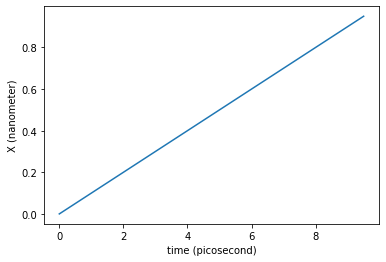

In [7]:
plt.plot(time, position[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

Si añadimos fricción el sistema se amortigua hasta perder la energía cinética inicial:

In [10]:
time, position, velocity, kinetic_energy, potential_energy = newtonian (free_particle.system,
                                                                        friction = 0.5 / unit.picoseconds,
                                                                        initial_positions = initial_positions,
                                                                        initial_velocities = initial_velocities,
                                                                        integration_timestep = 0.02 * unit.picoseconds,
                                                                        saving_timestep = 0.5 * unit.picoseconds,
                                                                        total_time = 10 * unit.picoseconds)

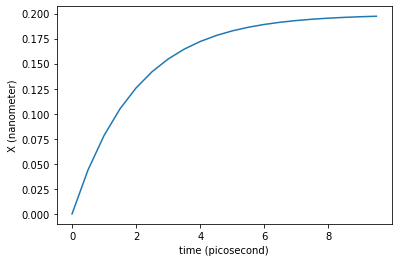

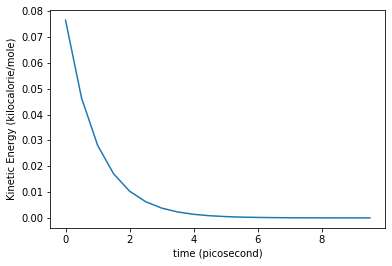

In [11]:
plt.plot(time, position[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

plt.plot(time, kinetic_energy[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('Kinetic Energy ({})'.format(kinetic_energy.unit))
plt.show()

## Simulación de dinámica de Langevin

Podemos simular la dinámica de Langevin con el siguiente script:

In [14]:
# %load scripts/particula_libre_langevin_1.py
import numpy as np
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit
import pickle

# Definición del sistema.
n_particles = 1 # número de partículas
mass = 180.15 * unit.amu # masa de la glucosa

# Definición de las condiciones del estado termodinámico.
temperature = 300*unit.kelvin # temperatura

# Condiciones iniciales
initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.nanometers # posiciones iniciales
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.nanometers/unit.picoseconds # velocidades iniciales

# Parámetros de la simulación.
integration_timestep = 0.1*unit.picoseconds # paso del integrador
saving_timestep = 1*unit.picoseconds # tiempo de guardado
total_time = 1*unit.nanoseconds # tiempo total de simulación

n_steps = int(round(total_time/integration_timestep)) # número total de pasos de integración a simular
steps_per_cicle = int(round(saving_timestep/integration_timestep)) # pasos de integración por ciclo de guardado
n_cicles = int(round(n_steps/steps_per_cicle)) # número total de ciclos de guardado a simular

# Creación del sistema.
system = mm.System()
for ii in range(num_particles):
    system.addParticle(mass)

# Creación del integrador.
friction = 5.0/unit.picosecond # damping del Langevin
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Creación de la plataforma.
platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

# Creación del contexto.
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

# Creación de arrays reporteros del tiempo, la posición y la velocidad.
times = np.zeros([n_cicles], np.float32) * unit.picoseconds
positions = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
velocities = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
kinetic_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole
potential_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole

# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0
state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energy[0] = state.getKineticEnergy()
potential_energy[0] = state.getPotentialEnergy()

# Ejecuto el bucle sobre el número de ciclos de guardado que vamos a simular
for ii in range(1,n_cicles):
    context.getIntegrator().step(steps_per_cicle)
    state = context.getState(getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energy[ii] = state.getKineticEnergy()
    potential_energy[ii] = state.getPotentialEnergy()

# Guardo, si es necesario, en un fichero pickle el resultado de la simulación
filename_traj = 'trajectory.pickle'
file_traj = open(filename_traj,'wb')
pickle.dump( times, file_traj )
pickle.dump( positions, file_traj )
pickle.dump( velocities, file_traj )
file_traj.close()



Podemos también simular este sistema desde la librería UIBCDF_tests_systems de una manera mas cómoda.

In [15]:
# %load scripts/particula_libre_langevin_2.py
from uibcdf_test_systems import FreeParticle
from uibcdf_test_systems.simulation import langevin_NVT
import numpy as np
from simtk import unit


# Sistema de test con el sistema de OpenMM como atributo
free_particle = FreeParticle(n_particles = 1, mass = 64 * unit.amu)

# Posiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

# Simulación de Langevin
time, position, velocity, kinetic_energy, potential_energy = langevin_NVT (free_particle.system,
                                                                           temperature = 300*unit.kelvin,
                                                                           friction = 0.5/unit.picoseconds,
                                                                           initial_positions = initial_positions,
                                                                           initial_velocities = initial_velocities,
                                                                           integration_timestep = 0.02 * unit.picoseconds,
                                                                           saving_timestep = 0.5 * unit.picoseconds,
                                                                           total_time = 10 * unit.picoseconds)


Veamos ahora un ejemplo de cómo se comporta la partícula libre regida por la dinámica de Langevin:

In [18]:
from uibcdf_test_systems import FreeParticle
from uibcdf_test_systems.simulation import langevin_NVT
import numpy as np
from simtk import unit

# Sistema de test con el sistema de OpenMM como atributo
free_particle = FreeParticle(n_particles = 1, mass = 64 * unit.amu)

# Posiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

# Simulación de Langevin
time, position, velocity, kinetic_energy, potential_energy = langevin_NVT (free_particle.system,
                                                                           temperature = 300*unit.kelvin,
                                                                           friction = 0.5/unit.picoseconds,
                                                                           initial_positions = initial_positions,
                                                                           initial_velocities = initial_velocities,
                                                                           integration_timestep = 0.05 * unit.picoseconds,
                                                                           saving_timestep = 1.0 * unit.picoseconds,
                                                                           total_time = 1 * unit.nanoseconds)

Representamos en primer lugar gráficamente la evolución en el tiempo de cada una de las tres coordenadas espaciales en función del tiempo.

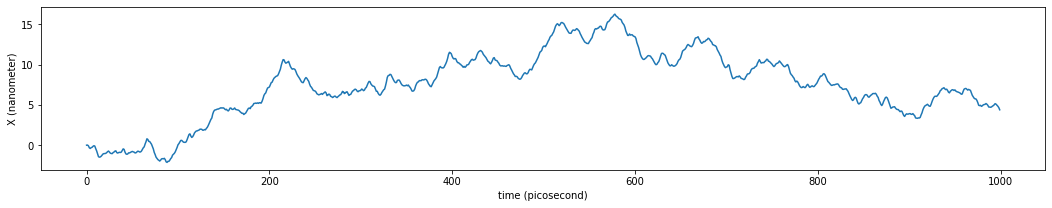

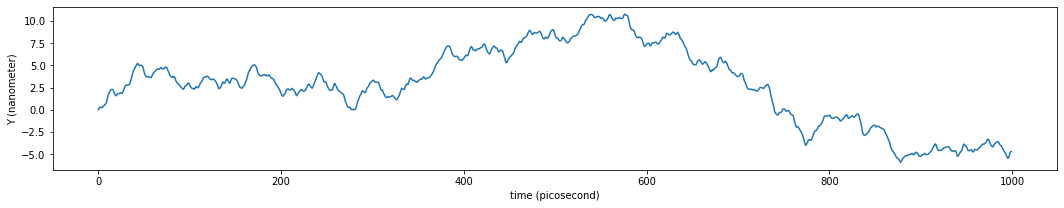

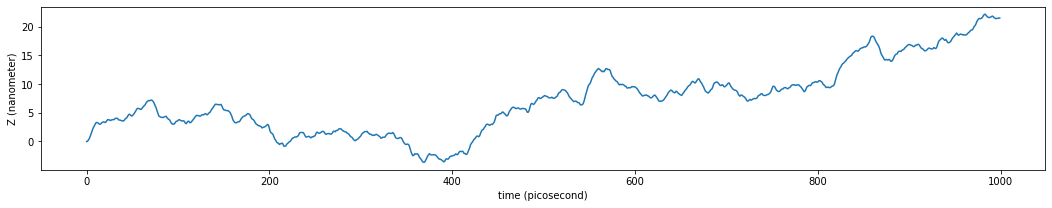

In [20]:
plt.rcParams['figure.figsize'] = 18, 3

plt.plot(time, position[:,0,0])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

plt.plot(time, position[:,0,1])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('Y ({})'.format(position.unit))
plt.show()

plt.plot(time, position[:,0,2])
plt.xlabel('time ({})'.format(time.unit))
plt.ylabel('Z ({})'.format(position.unit))
plt.show()

O si preferimos, la trayectoria proyectada por el espacio de dos de las dimensiones, por ejemplo $X$ y $Y$:

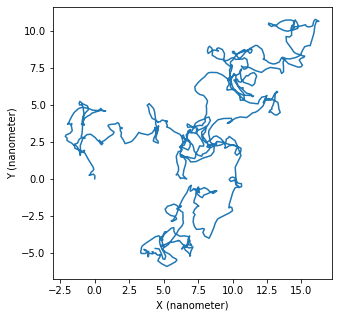

In [23]:
plt.rcParams['figure.figsize'] = 5, 5

plt.plot(position[:,0,0], position[:,0,1])
plt.xlabel('X ({})'.format(position.unit))
plt.ylabel('Y ({})'.format(position.unit))
plt.show()


Podemos ahora por último estudiar la difusion de la partícula estudiando una larga trayectoria de una partícula, o muchas trayectorias más cortas.